In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# 1. Long Short Term Memory
<br />

### Random Seed 설정

In [0]:
tf.set_random_seed(5)

- Parameter Tuning을 위해 Random Seed 설정

### Scale 함수 정의

In [0]:
# max-min scaling 함수
# 1e-8은 0으로 나눌 때 오류가 없게 하기 위함
def max_min_scaling(x):
    input_np = np.asarray(x)
    return (input_np - input_np.min())/(input_np.max() - input_np.min() + 1e-8)

# Reverse scaling 함수
def rev_max_min_scaling(org, x):
    org_input_np = np.asarray(org)
    input_np = np.asarray(x)
    return (input_np * (org_input_np.max() - org_input_np.min() + 1e-8)) + org_input_np.min()

### 데이터 로딩

In [0]:
raw_data = pd.read_csv('baba.csv'
                            , names = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volumn']
                            , encoding = 'euc-kr')


del raw_data['Date'] # Date 컬럼 삭제
stock_data = raw_data.values.astype(np.float) # 모든 컬럼 타입을 float으로 변환

print(raw_data.head(5))
print('\n\n',stock_data[:5,:])

        Open       High        Low      Close  Adj Close     Volumn
0  92.699997  99.699997  89.949997  93.889999  93.889999  271879400
1  92.699997  92.949997  89.500000  89.889999  89.889999   66657800
2  88.940002  90.480003  86.620003  87.169998  87.169998   39009800
3  88.470001  90.570000  87.220001  90.570000  90.570000   32088000
4  91.089996  91.500000  88.500000  88.919998  88.919998   28598000


 [[9.2699997e+01 9.9699997e+01 8.9949997e+01 9.3889999e+01 9.3889999e+01
  2.7187940e+08]
 [9.2699997e+01 9.2949997e+01 8.9500000e+01 8.9889999e+01 8.9889999e+01
  6.6657800e+07]
 [8.8940002e+01 9.0480003e+01 8.6620003e+01 8.7169998e+01 8.7169998e+01
  3.9009800e+07]
 [8.8470001e+01 9.0570000e+01 8.7220001e+01 9.0570000e+01 9.0570000e+01
  3.2088000e+07]
 [9.1089996e+01 9.1500000e+01 8.8500000e+01 8.8919998e+01 8.8919998e+01
  2.8598000e+07]]


- pandas로 data를 읽은 후 Array로 변환

### Hyper Parameter 정의

In [0]:
input_data_column_cnt = 6  # 입력 데이터 컬럼 개수 (Number of Variable)
output_data_column_cnt = 1 # 출력 데이터 컬럼 개수 (Number of Variable)

seq_length = 28            # 1개 Sequence의 길이(시계열 데이터 입력 갯수)
rnn_cell_hidden_dim = 28   # Hidden State 노드 개수
num_stacked_layers = 2     # LSTM Layerr 개수
keep_prob = 1.0            # Dropout할 때 Keep 할 비율

epoch_num = 1000           # 반복 횟수
learning_rate = 0.01       # learning rate

- LSTM 학습을 위한 parameter 설정

### 데이터 전처리

In [0]:
#Scale이 다른 Volumn을 제외한 컬럼들(Stock Price 관련) 선택 후 정규화
price = stock_data[:, :-1] #'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volumn' 중 Volumn 제외 후 데이터 선택
norm_price = max_min_scaling(price)
print("price.shape:", price.shape)
print("\n정규화 전 price[0]:", price[0])
print("\n정규화 후 norm_price[0]:", norm_price[0])
print("\n","="*130)

#Volumn 컬럼 정규화
volum = stock_data[:, -1:] #'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volumn' 중 Volumn 선택
norm_volum = max_min_scaling(volum)
print("volum.shape:", volum.shape)
print("\n정규화 전 volum[0]:", volum[0])
print("\n정규화 후 norm_volum[0]:", norm_volum[0])
print("\n","="*130)

# Input Data 결합
x = np.concatenate((norm_price, norm_volum), axis = 1) 
print("x.shape:", x.shape) #'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volumn' 컬럼으로 구성
print("\nx[0]:", x[0])     
print("\nx[-1]:", x[-1])
print("\n","="*130)

# Target 변수로 Adj Close(수정된 그날의 주식 종가 선택)
y = x[:,[-2]]
print("y.shape:", y.shape) 
print("\ny[0]:", y[0])     
print("\ny[-1]:", y[-1])
print("\n","="*130)

price.shape: (846, 5)

정규화 전 price[0]: [92.699997 99.699997 89.949997 93.889999 93.889999]

정규화 후 norm_price[0]: [0.23907331 0.28621453 0.22055354 0.24708733 0.24708733]

volum.shape: (846, 1)

정규화 전 volum[0]: [2.718794e+08]

정규화 후 norm_volum[0]: [1.]

x.shape: (846, 6)

x[0]: [0.23907331 0.28621453 0.22055354 0.24708733 0.24708733 1.        ]

x[-1]: [0.99420836 1.         0.97393767 0.9819516  0.9819516  0.06763526]

y.shape: (846, 1)

y[0]: [0.24708733]

y[-1]: [0.9819516]



- 학습의 정확도를 높히기 위해 모든 컬럼을 정규화 시킴

### LSTM Input으로 입력하기 위한 Shape로 변환

In [0]:
dataX = []
dataY = []


# X 데이터는 seq_length 만큼 데이터를 자른 후 하나의 Input으로 변환하고, Target 데이터는 seq_length+1의 값으로 생성 함
for i in range(0, len(y) - seq_length):
    x_ = x[i : i + seq_length]
    y_ = y[i + seq_length]
    if i is 0:
        print(x_, "->", y_)
    dataX.append(x_)
    dataY.append(y_)

[[0.23907331 0.28621453 0.22055354 0.24708733 0.24708733 1.        ]
 [0.23907331 0.24075692 0.21752306 0.22014949 0.22014949 0.23454509]
 [0.21375177 0.22412285 0.19812783 0.20183175 0.20183175 0.13142097]
 [0.21058657 0.22472893 0.20216849 0.22472893 0.22472893 0.10560338]
 [0.22823082 0.23099198 0.2107886  0.21361706 0.21361706 0.09258605]
 [0.219072   0.22398813 0.21186614 0.22398813 0.22398813 0.05432479]
 [0.21833121 0.21886993 0.20755604 0.21247221 0.21247221 0.08029232]
 [0.21415583 0.22681659 0.21051921 0.21314564 0.21314564 0.07700031]
 [0.21213547 0.21375177 0.19422183 0.19462588 0.19462588 0.0755464 ]
 [0.19577073 0.20876824 0.19133274 0.20109096 0.20109096 0.06599824]
 [0.2080948  0.22048623 0.20506432 0.2080948  0.2080948  0.05486824]
 [0.21516601 0.21853324 0.20782542 0.20950904 0.20950904 0.02048868]
 [0.20708462 0.21886993 0.20109096 0.20519898 0.20519898 0.03363022]
 [0.20742137 0.2107886  0.20109096 0.20944173 0.20944173 0.02415965]
 [0.21085596 0.22324734 0.20742137

- LSTM을 학습시키기 위해 Input data의 shape변경 
- x: [seq1, seq2, seq3, ....,seq_length]
- y: [seq_length+1]

### 데이터 분할

In [0]:
# 분할 비율 index 생성 (Train, test = 7:3)
train_size = int(len(dataY)*0.7)
test_size = len(dataY) - train_size

# Train data 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

# Test data 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataX)])

- 학습 전 Train/Test data로 데이터 분할

### Tensor Graph 생성

In [0]:
tf.reset_default_graph() #RNN Graph 초기화

X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X : ",X)

Y = tf.placeholder(tf.float32, [None, 1])
print("Y : ",Y)

##Target, Prediction Graph for test
target = tf.placeholder(tf.float32, [None, 1])
print("target : ",target)

prediction = tf.placeholder(tf.float32, [None, 1])
print("prediction : ",prediction)

X :  Tensor("Placeholder:0", shape=(?, 28, 6), dtype=float32)
Y :  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
target :  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
prediction :  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


- Tensor Graph 생성 전 모든 graph를 초기화
- x, y, target, prediction을 저장할 placeholder 생성

In [0]:
#lstm Cell 생성 함수 정의
def lstm_cell():
    # num_units: 각 Cell 출력 크기
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell
 
# num_stacked_layers개의 층으로 쌓인 Stacked LSTM 생성
multi_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(num_stacked_layers)]
                                          , state_is_tuple=True)
 
# LSTM셀 연결
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)

print("hypothesis: ", hypothesis)
 
# LSTM의 마지막 hidden 출력만을 사용 --> [:, -1]
# 과거 여러 스텝으로 다음날의 주가 1개를 예측  --> MANY-TO-ONE 형태
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1]
                                               , output_data_column_cnt
                                               , activation_fn=tf.identity)

# Cost Function은  MSE 사용
cost = tf.reduce_sum(tf.square(hypothesis - Y))

# 최적화함수로 AdamOptimizer를 사용
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

hypothesis:  Tensor("rnn/transpose:0", shape=(?, 28, 28), dtype=float32)


- LSTM layer를 여러층을 쌓기 위해 lstm cell 함수를 작성
- 사용자가 지정한 층의 개수 만큼 Layer를 쌓아서 Stacked LSTM 생성 하고 dynamic_rnn으로 모든 셀을 연결

In [0]:
# RMSE(Root Mean Square Error)
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(target, prediction)))
train_error_summary = [] # train error 기록을 위한 list 생성
test_error_summary = []  # test error 기록을 위한 list 생성
test_predict = ''        # test data로 예측한 결과

### Tensor Graph 실행 (Training)

In [0]:
#Session 정의 후 글로벌 초기화
sess = tf.Session()
sess.run(tf.global_variables_initializer())
 
#시작 시간
start_time = datetime.datetime.now() 
print('학습을 시작하겠습니다')


for epoch in range(epoch_num):
    _, _cost = sess.run([optimizer, cost], feed_dict={X: trainX, Y: trainY}) #모델 학습
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): 
        # train data rmse
        train_predict = sess.run(hypothesis, feed_dict={X: trainX}) #train으로 predict
        train_error = sess.run(rmse, feed_dict={target: trainY, prediction: train_predict})
        train_error_summary.append(train_error)
 
        # test data rmse
        test_predict = sess.run(hypothesis, feed_dict={X: testX}) #test로 predict
        test_error = sess.run(rmse, feed_dict={target: testY, prediction: test_predict})
        test_error_summary.append(test_error)
        
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
print('학습이 완료되었습니다')
end_time = datetime.datetime.now()   # 종료시간
elapsed_time = end_time - start_time # 경과시간

학습을 시작하겠습니다
epoch: 100, train_error(A): 0.018037816509604454, test_error(B): 0.09088239073753357, B-A: 0.07284457236528397
epoch: 200, train_error(A): 0.01580023393034935, test_error(B): 0.06009573116898537, B-A: 0.04429549723863602
epoch: 300, train_error(A): 0.013452465645968914, test_error(B): 0.05323633924126625, B-A: 0.03978387266397476
epoch: 400, train_error(A): 0.012819578871130943, test_error(B): 0.06322828680276871, B-A: 0.050408706068992615
epoch: 500, train_error(A): 0.011713838204741478, test_error(B): 0.05894613638520241, B-A: 0.04723230004310608
epoch: 600, train_error(A): 0.01147305779159069, test_error(B): 0.061685577034950256, B-A: 0.050212517380714417
epoch: 700, train_error(A): 0.011339394375681877, test_error(B): 0.06812093406915665, B-A: 0.05678153783082962
epoch: 800, train_error(A): 0.011234979145228863, test_error(B): 0.0775105431675911, B-A: 0.06627556681632996
epoch: 900, train_error(A): 0.011144031770527363, test_error(B): 0.09046881645917892, B-A: 0.0793247

- train과 test의 loss는 서로 trade off 관계로 판단됨.
- 적적한 Epoch 설정 필요

In [0]:
##########################################################
# 학습 결과 Parameter 출력
##########################################################
print("\n","="*130)
print('\n총 학습 시간:',elapsed_time)
print('\n1번 학습 시간:',elapsed_time/epoch_num)
 
print('\nInput 컬럼 개수:', input_data_column_cnt, end='')
print('\nOutput 컬럼 개수:', output_data_column_cnt, end='')
 
print('\ntrain_error:', train_error_summary[-1], end='')
print('\ntest_error:', test_error_summary[-1], end='')
print('\nmin_test_error:', np.min(test_error_summary))



총 학습 시간: 0:08:24.453439

1번 학습 시간: 0:00:00.504453

Input 컬럼 개수: 6
Output 컬럼 개수: 1
train_error: 0.011099991
test_error: 0.10373895
min_test_error: 0.05323634


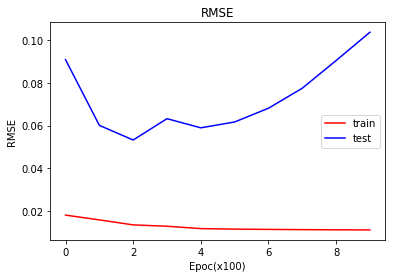

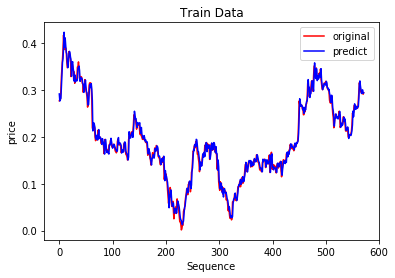

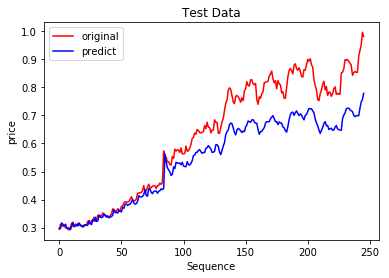

In [0]:
##########################################################
# 결과 Plot 출력
##########################################################
plt.plot(train_error_summary, 'r', label='train')
plt.plot(test_error_summary, 'b', label='test')
plt.legend()
plt.title('RMSE')
plt.xlabel('Epoc(x100)')
plt.ylabel('RMSE')
plt.show()

plt.plot(trainY, 'r', label='original')
plt.plot(train_predict, 'b', label='predict')
plt.legend()
plt.xlabel('Sequence')
plt.ylabel('price')
plt.title('Train Data')
plt.show()

plt.plot(testY, 'r', label='original')
plt.plot(test_predict, 'b', label='predict')
plt.legend()
plt.xlabel('Sequence')
plt.ylabel('price')
plt.title('Test Data')
plt.show()

In [0]:
# 내일 stock price 예측을 위해 Input 설정
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data(Input):", recent_data)

recent_predict = sess.run(hypothesis, feed_dict={X: recent_data})
 
print("예측값(정규화 전)", test_predict[0])
rev_test_predict = rev_max_min_scaling(price,recent_predict) # 금액 데이터 역정규화 함
print("예측값(역정규화 후)", rev_test_predict[0])            # 예측한 주가 출력

recent_data.shape: (1, 28, 6)
recent_data(Input): [[[0.79062566 0.79129905 0.77560774 0.7823422  0.7823422  0.04941364]
  [0.772914   0.77985048 0.76308164 0.7682672  0.7682672  0.07519803]
  [0.77170174 0.779177   0.76503469 0.77742607 0.77742607 0.04977954]
  [0.77850361 0.80173748 0.77750016 0.79547448 0.79547448 0.04116722]
  [0.79897632 0.80449863 0.79358873 0.80200681 0.80200681 0.03263434]
  [0.79028892 0.79432953 0.77129769 0.77533841 0.77533841 0.03408564]
  [0.77506897 0.78570943 0.77129769 0.77964846 0.77964846 0.02378554]
  [0.78011981 0.78341974 0.77089364 0.77513638 0.77513638 0.02138274]
  [0.77500166 0.78436256 0.76772843 0.77601179 0.77601179 0.02211566]
  [0.80274093 0.85460303 0.79803351 0.85157244 0.85157244 0.09750541]
  [0.86194357 0.86494035 0.83641991 0.85392955 0.85392955 0.06097109]
  [0.86672498 0.87916353 0.85682532 0.86544552 0.86544552 0.05855375]
  [0.87527777 0.89938715 0.8694255  0.89905041 0.89905041 0.05368437]
  [0.8974342  0.90551554 0.88807331 0.89